In [ ]:
davide = "loser"

In [ ]:
import os
import torch
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import models
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, Subset
import time
import random 
import json
from sklearn.metrics import f1_score

In [ ]:
if torch.backends.mps.is_built():
    device = torch.device("mps")
    print("M1 pro GPU is activated")
    import os
    os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '0'
else:
    device = torch.device("cuda")
    cuda_id = torch.cuda.current_device()
    print(f"ID of current CUDA device:{torch.cuda.current_device()}")
        
    print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

In [ ]:
torch.cuda.is_available()

We will import the images already resized 250 x 250

In [ ]:
with open('train.csv') as fp:
    # read a list of lines into data
    data = fp.readlines()

data[4790] = data[4790].replace("/", "")
data[14716] = data[14716].replace("/", "")
data[14961] = data[14961].replace("/", "")
data[29895] = data[29895].replace("/", "")

# and write everything back
with open('train.csv', 'w') as file:
    file.writelines(data)

In [ ]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [ ]:
import re
import pandas as pd
from io import StringIO
FILENAME = 'test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    df_test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [ ]:
for i in range(df_train.shape[0]):
    df_train.Labels[i] = [int(j) for j in df_train.Labels[i].split()]
max_i = 0
for i in df_train.Labels:
    max_i = max(max_i, max(i))
min_i = 19
for i in df_train.Labels:
    min_i = min(min_i, min(i))
min_i

for i in range(1, max_i+1):
    df_train[f'{i}'] = 0
for i in range(df_train.shape[0]):
    for j in df_train.Labels[i]:
        df_train[f"{j}"][i] = 1
df_train.to_csv("df_train.csv", index=False)

In [ ]:
df_train.head()

In [ ]:
for i in range(df_train.shape[0]):
    if f"{i}.jpg" != df_train.loc[i,'ImageID']:
        print(i)

In [ ]:
df_train = pd.read_csv("df_train.csv")

In [ ]:
df_train.head()

# Distribution of Labels

In [ ]:
labels = df_train['Labels'].explode()

# Plot the distribution of labels using a bar plot
plt.figure(figsize=(10, 6))
label_counts = labels.value_counts()
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')

# Set custom x-tick labels
plt.xticks(range(len(label_counts)), label_counts.index, rotation=45)

plt.show()

In [ ]:
labels = df_train['Labels'].explode()

# Get the label counts
label_counts = labels.value_counts().sort_index()

# Add missing label if it doesn't exist
if '12' not in label_counts.index:
    label_counts['12'] = 0

# Sort labels based on their values
label_counts = label_counts.sort_values()

# Plot the distribution of labels using a bar plot
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels')

# Set custom x-tick labels
plt.xticks(range(len(label_counts)), label_counts.index, rotation=45)

plt.show()

In [ ]:
df_train = df_train.drop(['12'], axis=1)
df_train.head()

## Dataloaders

In [ ]:
from torch.utils.data import Dataset

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

class TrainDataset(Dataset):
    def __init__(self, csv, train = True, test = False,full=False):
        self.csv = csv # df_train
        self.train = train # boolean
        self.full = full
        self.test = test # boolean

        self.all_image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']

        #self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))

        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio

        # set the training data images and labels
        if self.full == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))
            self.image_names = list(self.all_image_names)
            self.labels = list(self.all_labels)
            print(f"Number of training images: {self.all_labels.shape[0]}")
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                # transforms.ColorJitter(),
                transforms.Normalize(mean, std)

            ])
        elif self.train == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels', 'Caption'], axis=1))
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            self.captions = list(self.captions[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                # transforms.ColorJitter(),
                transforms.Normalize(mean, std)
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == True:
            self.all_labels = np.array(self.csv.drop(['ImageID', 'Labels','Caption'], axis=1))
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:])
            self.labels = list(self.all_labels[-self.valid_ratio:])
            self.captions = list(self.captions[-self.valid_ratio:])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)

            ])
            
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        name = self.image_names[index]
        image = Image.open(f'data/{name}')
        image = self.transform(image)
        caption = self.captions[index]
        if self.train == True:   #training
            targets = self.labels[index]
            return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'name' : name,
            'caption' : caption,
        }
        elif self.train == False and self.test == True:  #validation
             targets = self.labels[index]
             return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32),
            'caption' : caption,
            'name' : name,
        }
        elif self.test == True and self.train == False:   #testing
            return {
            'image': torch.tensor(image, dtype=torch.float32),
            'name' : name,
            'caption' : caption,
        }
       
        
        

In [ ]:
class TestDataset(Dataset):
    def __init__(self, csv):
        self.csv = csv
        self.image_names = self.csv[:]['ImageID']
        self.captions = self.csv[:]['Caption']
        print(f"Number of test images: {len(self.csv)}")
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
            
        ])
            
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        name = self.image_names[index]
        image = Image.open(f'data/{name}')
        image = self.transform(image)
        caption = self.captions[index]
        return {
        'image': torch.tensor(image, dtype=torch.float32),
        'name' : name,
        'caption' : caption,
        }
       

In [ ]:
batch_size = 32
train_data = TrainDataset(
    df_train, train=True, test=False
)
# validation dataset
valid_data = TrainDataset(
    df_train, train=False, test=True
)

full_data = TrainDataset(
   csv = df_train, full=True
)

test_data = TestDataset(
    csv = df_test
)

train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)
# validation data loader
valid_loader = DataLoader(
    valid_data, 
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

full_loader = DataLoader(
    full_data,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
valid_data[0]['caption'], valid_data[0]['name']

In [ ]:
type(valid_data[0]['image'].dtype)

In [ ]:
plt.imshow(valid_data[0]['image'].permute(1, 2, 0))
plt.show()

In [ ]:
train_data[0]['caption'], train_data[0]['name'] 

In [ ]:
plt.imshow(train_data[0]['image'].permute(1, 2, 0))

In [ ]:
test_data[len(test_data) -1]['caption'], test_data[len(test_data) -1]['name']

In [ ]:
plt.imshow(test_data[len(test_data) -1]['image'].permute(1, 2, 0))

## Function for predicting the labels on the test set

In [ ]:
def predict_test_data_vision(model, test_loader, device):
    model.eval()
    model = model.to(device)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            #images
            batch_size = len(data['image'])
            images = data['image'].to(device)
            pred = model(images)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1
            # print(indices)
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

In [ ]:
def predict_test_data_caption(model, test_loader, device, tokenizer, seq_len, word_index):
    model.eval()
    y_pred = torch.zeros(len(test_data), 18)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            batch_size = len(data['caption'])
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)
            #captions = data['Caption'].to(device)
            pred = model(captions)
            _, argmax_indices = torch.max(pred, dim=1)
            pred[torch.arange(pred.size(0)), argmax_indices] = 1
            pred = (pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1 ### incrementing labels that are bigger than 10, since we eliminated the 12 label
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results


    return df_pred

In [ ]:
def predict_test_data_combined(best_cv_model, best_nlp_model, classifier, test_loader, device, tokenizer, seq_len, word_index):
    best_cv_model.eval()
    best_nlp_model.eval()
    classifier.eval()
    y_pred = torch.zeros(len(test_data), 18)
    df_pred = pd.DataFrame()
    df_pred['ImageID'] = ["" for i in range(len(test_data))]
    df_pred['Labels'] = ["" for i in range(len(test_data))]
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            batch_size = len(data['caption'])
            print(batch_size)
            #captions
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)

            #images
            images = data['image'].to(device)

            #captions = data['Caption'].to(device)
            #optimizer.zero_grad()
            img_out = best_cv_model(images)
            nlp_out = best_nlp_model(captions)
            concatenating_outs = torch.concat((img_out, nlp_out), 1)
            combined_model_pred = classifier(concatenating_outs)
            _, argmax_indices = torch.max(combined_model_pred, dim=1)
            combined_model_pred[torch.arange(combined_model_pred.size(0)), argmax_indices] = 1
            combined_model_pred = (combined_model_pred >= 0.5).type(torch.uint8)
            start = i*batch_size
            end = min((i+1)*batch_size, len(test_data))
            indices = combined_model_pred.nonzero()
            indices[indices[:, 1] > 10, 1] += 1 ### incrementing labels that are bigger than 10, since we eliminated the 12 label       
            indices_by_row = torch.split(indices[:, 1], indices[:, 0].unique(return_counts=True)[1].tolist())
            results = [" ".join([str(idx.item()+1) for idx in row]) for row in indices_by_row]
            df_pred["ImageID"][start:end] = data['name']
            df_pred["Labels"][start:end] = results

    return df_pred

## Computer Vision Models


### AlexNet


In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
class AlexNet_1(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        alexnet = AlexNet_model.to(device)
        alexnet.classifier[6] = nn.Linear(alexnet.classifier[6].in_features,num_classes)
        self.base_model = alexnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

In [ ]:
AlexNet_model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
class AlexNet_2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        alexnet = AlexNet_model.to(device)
        alexnet.classifier[4] = nn.Linear(alexnet.classifier[4].in_features,1096)
        alexnet.classifier[6] = nn.Linear(1096,num_classes)
        self.base_model = alexnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

### Resnext

In [ ]:

#Use the torchvision's implementation of ResNeXt, but add FC layer for a different number of classes (27) and a Sigmoid instead of a default Softmax.
class Resnext50(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True).to(device=device)

        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

### ResNet

In [102]:
class Resnet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        resnet = models.resnet18(pretrained=True).to(device=device)
        resnet.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

    def calculate_f1_score_and_loss(self, loader, criterion, device=None):
        self.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):
                images = data['image'].to(device)
                target = data['label'].to(device)
                outputs = self(images).to(device)
                loss = criterion(outputs, target)
                val_loss[i] = loss.item()
                outputs = outputs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

In [103]:
best_cv_model = Resnet18(num_classes=18)
best_cv_model = best_cv_model.to(device)
best_cv_model.train()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Resnet18(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [104]:
save_freq = 3
lr = 1e-4
weight_decay = 1e-5
num_epochs = 20
optimizer = torch.optim.Adam(best_cv_model.parameters(),weight_decay=weight_decay, lr=lr)
criterion = nn.BCELoss()

In [105]:
name_of_model = f'Resnet18_lr={lr}_weight_decay={weight_decay}_dropout=0.5_original_model'
os.mkdir(name_of_model)
train_losses = np.zeros(num_epochs)
valid_losses = np.zeros(num_epochs)
f1_scores = np.zeros(num_epochs)
initial_lr = optimizer.param_groups[0]['lr']
for it in range(num_epochs):
    train_loss = 0
    for i, data in enumerate(train_loader):
        images = data['image'].to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_cv_model(images)
        loss = criterion(outputs, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    print(it)

    if ((it % save_freq == 0) or (it == num_epochs - 1)) and it > 0:
        checkpoint_path = f'{name_of_model}/{name_of_model}{it}.pth'
        checkpoint = {'model': best_cv_model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': num_epochs}
        torch.save(checkpoint, checkpoint_path)
    train_losses[it] = train_loss/len(train_loader)
    result = best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    valid_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']
    

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


0


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


1


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


2


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


3


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


4


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


5


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


6


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


7


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


8


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


9


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


10


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


11


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


12


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


13


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


14


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


15


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


16


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


17


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


18


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),
/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


19


/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


In [106]:
f1_scores

array([0.78817068, 0.77770771, 0.78325996, 0.79319001, 0.8028692 ,
       0.79498366, 0.79609065, 0.80616267, 0.79312722, 0.8110853 ,
       0.8053035 , 0.80309238, 0.80375572, 0.79297839, 0.79091517,
       0.79404372, 0.7954371 , 0.79290042, 0.78982501, 0.79113428])

In [107]:
max(f1_scores)

0.8110852974186308

In [108]:
best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)

/var/folders/yz/zpp3kyv15wgc4kxcns1r1_v80000gn/T/ipykernel_58729/653025415.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'image': torch.tensor(image, dtype=torch.float32),


KeyboardInterrupt: 

In [ ]:
submission = predict_test_data_vision(best_cv_model, test_loader=test_loader, device=device, batch_size = batch_size)
submission

In [ ]:
submission.to_csv('predictions.csv',index=False)

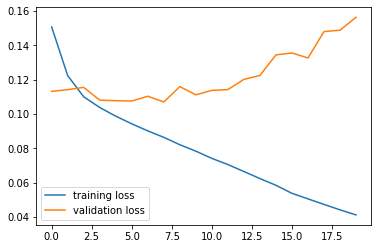

In [109]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),valid_losses,label = "validation loss")
plt.legend()
plt.savefig(f'{name_of_model}/learning_curve.png')
plt.show()

In [ ]:
f1_scores

In [110]:
dict1 ={
    "f1_scores": f1_scores.tolist(),
    "train_losses": train_losses.tolist(),
    "valid_losses": valid_losses.tolist()
}
  
# the json file where the output must be stored
out_file = open(f"{name_of_model}/myfile.json", "w")


json.dump(dict1, out_file, indent = 6)
  
out_file.close()

In [ ]:
best_cv_model = AlexNet_2(18)
checkpoint = torch.load("AlexNet_lr=0.0001_weight_decay=0_dropout=0.5/AlexNet_lr=0.0001_weight_decay=0_dropout=0.519.pth")
best_cv_model.load_state_dict(checkpoint['model'])
best_cv_model = best_cv_model.to(device)
best_cv_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)

# Language Models

In [76]:
df_train = df_train.drop(columns = 'Caption').join(df_train['Caption'].str.replace('\"', ''))
df_test = df_test.drop(columns = 'Caption').join(df_test['Caption'].str.replace('\"', ''))
whole_sentences = pd.concat([df_train['Caption'], df_test['Caption']], axis=0, ignore_index=True)
whole_sentences

0         Woman in swim suit holding parasol on sunny day.
1        A couple of men riding horses on top of a gree...
2        They are brave for riding in the jungle on tho...
3        a black and silver clock tower at an intersect...
4         A train coming to a stop on the tracks out side.
                               ...                        
39995    A group of men riding surfboards riding a mass...
39996    A motorcycle parked next to a car in a parking...
39997              a little boy that is playing with a wii
39998    group of kids play Frisbee golf in the middle ...
39999     A man in a gray jacket standing next to a woman.
Name: Caption, Length: 40000, dtype: object

### Creating a tokenizer

In [77]:
import re
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
from nltk.corpus import stopwords as sw
# stop_words = sw.words()
STOPWORDS = set(sw.words('english'))

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yaraslauivashynka/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yaraslauivashynka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yaraslauivashynka/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [78]:
def sent_split(input_string): # string to pure word
    splits = []
    for sent in input_string:
        # print(text)
        sent = sent.lower() # lowercase
        sent = re.sub(r'[^A-Za-z]+', ' ', sent) # remove symbols / digits
        # text = re.sub(r'[0-9]','',text)
        orig_sent = []
        for item in sent.split():
            if item not in STOPWORDS: # remove stopword
                orig_sent.append(item)

        lem = [lemmatizer.lemmatize(sent) for sent in orig_sent] # lammatisation

        # token = [word_tokenize(word) for word in text_le]
        splits.append(lem)
    return splits

In [79]:
max_seq_len = max(len(s) for s in sent_split(whole_sentences))
max_seq_len

28

In [80]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))
word_embedding_model = gensim.downloader.load('word2vec-google-news-300')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [81]:
splitted_sentences = sent_split(whole_sentences)
word_list = []
for sent in splitted_sentences:
    for word in sent:
        word_list.append(word)
len(word_list)

233353

In [82]:
vocab_list = []
for sent in splitted_sentences:
    for word in sent:
        vocab_list.append(word)

In [83]:
# Create the Embedding lookup table
import numpy as np
emb_dim = word_embedding_model.vector_size
word_set = set()
min_freq = 5
from collections import Counter
c = Counter(vocab_list)
for i in c:
    if c[i] >= min_freq:
        word_set.add(i)
word_set.add('[PAD]')
word_set.add('[UNKOWN]')
word_list=list(word_set)
word_list.sort()
emb_table = []
word_index = {}
emb_table = []
for i, word in enumerate(word_list):
    word_index[word] = i
    if word in word_embedding_model:
        emb_table.append(word_embedding_model[word])
    else:
        emb_table.append([0]*emb_dim)
emb_table = np.array(emb_table)
    
print(emb_table)
emb_table.shape

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.17480469  0.17871094  0.09082031 ...  0.07568359 -0.11181641
  -0.0625    ]
 ...
 [-0.08544922 -0.10253906 -0.48632812 ...  0.02075195  0.08496094
   0.00061035]
 [-0.07421875 -0.10205078  0.20117188 ... -0.25390625  0.06054688
  -0.21289062]
 [-0.04248047  0.16015625 -0.2265625  ...  0.18945312 -0.00692749
   0.1328125 ]]


(2218, 300)

In [84]:
class Tokenizer:
    def __init__(self):
        pass
    def tokenize(self, sentences, seq_len, word_index):
        sentences = sent_split(sentences)
        sent_encoded = []
        for sent in sentences:
            temp_encoded = [word_index[word] if word in word_index else word_index['[UNKOWN]'] for word in sent]
            if len(temp_encoded) < seq_len:
                temp_encoded += [word_index['[PAD]']] * (seq_len - len(temp_encoded))
            else:
                temp_encoded = temp_encoded[:seq_len]
            sent_encoded.append(temp_encoded)
        return sent_encoded

In [85]:
vocab_size = emb_table.shape[0]
emb_dim = emb_table.shape[1]
vocab_size, emb_dim

(2218, 300)

## Defining models

In [92]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

n_hidden = 300

lr = 1e-4

seq_len = max_seq_len

class Bi_LSTM_Emb(nn.Module):
    def __init__(self,n_classes):
        super(Bi_LSTM_Emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.emb.weight.data.copy_(torch.from_numpy(emb_table))
        self.emb.weight.requires_grad = False

        self.lstm = nn.LSTM(emb_dim, n_hidden, batch_first =True, bidirectional=True)
        self.linear = nn.Linear(n_hidden*2, n_classes)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        x = self.emb(x)        
        lstm_out, (h_n,c_n) = self.lstm(x)
        hidden_out = torch.cat((h_n[0,:,:],h_n[1,:,:]),1)
        z = self.linear(hidden_out)
        return self.sigm(z)

    def calculate_f1_score_and_loss(self, loader, criterion, device):
            self.eval()
            val_loss = 0
            with torch.no_grad():
                y_pred = []
                y_true = []
                for data in loader:
                    captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
                    captions = torch.from_numpy(np.array(captions)).to(device)
                    target = data['label'].to(device)
                    outputs = self(captions)
                    loss = criterion(outputs, target)
                    val_loss += loss.item()
                    outputs = outputs.cpu().numpy()
                    argmax_indices = np.argmax(outputs, axis=1)
                    outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                    predicted = np.round(outputs)
                    y_pred.extend(predicted)
                    y_true.extend(target.cpu().numpy())
                y_pred = np.array(y_pred)
                y_true = np.array(y_true)
                res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
            return {'f1_score' : res, 'loss' : val_loss/len(loader)}

In [93]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

n_hidden = 300

lr = 1e-4

seq_len = max_seq_len

class LSTM(nn.Module):
  def __init__(self, n_class):
    super(LSTM, self).__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.emb.weight.data.copy_(torch.from_numpy(emb_table))
    self.emb.weight.requires_grad = False
    self.lstm = nn.LSTM(emb_dim, n_hidden, num_layers=2, batch_first =True, dropout=0.5)
    self.linear = nn.Linear(n_hidden,n_class)
    self.sigmoid = nn.Sigmoid()
  
  def forward(self, input):
    input = self.emb(input)
    input,_ = self.lstm(input)
    input = self.linear(input[:,-1,:])
    return self.sigmoid(input)
  
  def calculate_f1_score_and_loss(self, loader, criterion, device):
    self.eval()
    val_loss = 0
    with torch.no_grad():
        y_pred = []
        y_true = []
        for data in loader:
            captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
            captions = torch.from_numpy(np.array(captions)).to(device)
            target = data['label'].to(device)
            outputs = self(captions)
            loss = criterion(outputs, target)
            val_loss += loss.item()
            outputs = outputs.cpu().numpy()
            argmax_indices = np.argmax(outputs, axis=1)
            outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
            predicted = np.round(outputs)
            y_pred.extend(predicted)
            y_true.extend(target.cpu().numpy())
        y_pred = np.array(y_pred)
        y_true = np.array(y_true)
        res = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    return {'f1_score' : res, 'loss' : val_loss/len(loader)}


In [94]:
best_nlp_model = Bi_LSTM_Emb(18)
best_nlp_model = best_nlp_model.to(device)
best_nlp_model.train()

Bi_LSTM_Emb(
  (emb): Embedding(2218, 300)
  (lstm): LSTM(300, 300, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=600, out_features=18, bias=True)
  (sigm): Sigmoid()
)

In [97]:
tokenizer = Tokenizer()
save_freq = 3
lr = 1e-4
weight_decay = 0
num_epochs = 20
optimizer = torch.optim.Adam(best_nlp_model.parameters(), weight_decay=weight_decay, lr=lr)
criterion = nn.BCELoss()

In [ ]:
name_of_model = f'BiLSTM_lr={lr}_weight_decay={weight_decay}_dropout=0.5'
os.mkdir(name_of_model)
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
for it in range(num_epochs):
    train_loss = 0
    best_nlp_model.train()
    for i, data in enumerate(train_loader):
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)
        target = data['label'].to(device)
        optimizer.zero_grad()
        outputs = best_nlp_model(captions)
        loss = criterion(outputs, target)
        train_loss+=loss.item()
        if i % 500 == 0:
            print(loss.item())
        loss.backward()
        optimizer.step()
    if ((it % save_freq == 0) or (it == num_epochs - 1)) and it > 0:
        checkpoint_path = f'{name_of_model}/{name_of_model}{it}.pth'
        checkpoint = {'model': best_cv_model.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': num_epochs}
        torch.save(checkpoint, checkpoint_path)        
    print(it)
    train_losses[it] = train_loss/len(train_loader)
    result = best_nlp_model.calculate_f1_score_and_loss(valid_loader, criterion=criterion, device=device)
    val_losses[it] = result['loss']
    f1_scores[it] = result['f1_score']

In [101]:
train_losses


tensor([0.2237, 0.2004, 0.2005, 0.2005, 0.2005, 0.2005, 0.2005, 0.2005, 0.2005,
        0.2006, 0.2005, 0.2005, 0.2005, 0.2005, 0.2005, 0.2005, 0.2005, 0.2006,
        0.2005, 0.2005])

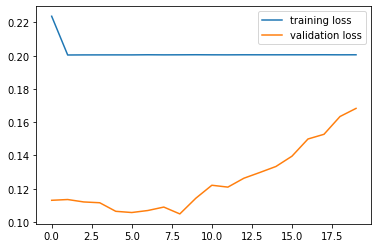

In [100]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),valid_losses,label = "validation loss")
plt.legend()
plt.savefig(f'{name_of_model}/learning_curve.png')
plt.show()

In [ ]:
dict1 ={
    "f1_scores": f1_scores.tolist(),
    "train_losses": train_losses.tolist(),
    "valid_losses": valid_losses.tolist()
}
  
# the json file where the output must be stored
out_file = open(f"{name_of_model}/myfile.json", "w")
json.dump(dict1, out_file, indent = 6)
  
out_file.close()

# COMBINED MODEL

In order to combine the NLP and classification model we need to concatenate the features and run a third classifier on this concatenated features

Define the third classifier

In [ ]:
def calculate_f1_score_and_loss(model, best_nlp_model, best_cv_model, loader, criterion, seq_len, word_index, tokenizer, device=None):
        model.eval()
        best_nlp_model.eval()
        best_cv_model.eval()
        val_loss = torch.zeros(len(loader))
        with torch.no_grad():
            y_pred = []
            y_true = []
            for i, data in enumerate(loader):

                captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
                captions = torch.from_numpy(np.array(captions)).to(device)

                images = data['image'].to(device)
                target = data['label'].to(device)

                image_outs = best_cv_model(images)
                text_outs = best_nlp_model(captions)

                concatenating_outs = torch.concat((image_outs, text_outs), 1)
                combined_outs = classifier(concatenating_outs)

                loss = criterion(combined_outs, targets.type(torch.float))
                val_loss[i] = loss.item()
                outputs = combined_outs.cpu().numpy()
                argmax_indices = np.argmax(outputs, axis=1)
                outputs[np.arange(outputs.shape[0]), argmax_indices] = 1
                predicted = np.round(outputs)
                y_pred.extend(predicted)
                y_true.extend(target.cpu().numpy())
            y_pred = np.array(y_pred)
            y_true = np.array(y_true)
            res = f1_score(y_true=y_true, y_pred=y_pred, average='samples')
        return {'f1_score' : res, 'loss' : val_loss.mean()}

In [ ]:
n_labels = 18

best_cv_model = Resnext50(num_classes=n_labels)
best_nlp_model = Bi_LSTM_Emb(n_classes=n_labels)
checkpoint = torch.load("ResNet4.pth")
# Load the model state dictionary from the checkpoint
best_cv_model.load_state_dict(checkpoint['model'])

checkpoint = torch.load("BiLSTM3.pth")
# Load the model state dictionary from the checkpoint
best_nlp_model.load_state_dict(checkpoint['model'])
# Define Classifier
classifier = nn.Sequential(
    nn.Linear(in_features=36, out_features=3100),
    nn.ReLU(),
    nn.Linear(in_features=3100, out_features=n_labels),
    nn.Sigmoid()
)


# Switch model to GPU.
best_cv_model = best_cv_model.to(device)
best_nlp_model = best_nlp_model.to(device)
classifier = classifier.to(device)

tokenizer = Tokenizer()
     

In [ ]:
criterion = nn.BCELoss().to(device=device)
optimizer = optim.Adam(classifier.parameters(), lr=lr)

In [ ]:
epochs = 20
train_losses = torch.zeros(num_epochs)
val_losses = torch.zeros(num_epochs)
f1_scores = torch.zeros(num_epochs)
name_of_model = "combined_model"
saving_freq = 3
os.mkdir(name_of_model)
for epoch in range(epochs):
    classifier.train()
    batch_loss_values = []
    train_loss=0
    for data in train_loader:
        best_cv_model.train()
        best_nlp_model.train()

        targets = data['label'].to(device)
        images = data['image'].to(device)
       
        captions = tokenizer.tokenize(data['caption'], seq_len, word_index)
        captions = torch.from_numpy(np.array(captions)).to(device)

        optimizer.zero_grad()
        img_out = best_cv_model(images)
        nlp_out = best_nlp_model(captions)
        concatenating_outs = torch.concat((img_out, nlp_out), 1)

        combined_model = classifier(concatenating_outs)
        
        #loss and backward pass
        loss = criterion(combined_model, targets.type(torch.float))
        train_loss += loss.item()
        if i % 100 == 0:
            print(loss.item())
        # bl_value = loss.item()
        # print(bl_value)

        loss.backward()
        

        optimizer.step()
    
    if ((epoch % saving_freq == 0) or (epoch == epochs - 1)) and epoch > 0:
        checkpoint_path = f'{name_of_model}/{name_of_model}{epoch}.pth'
        checkpoint = {'model': classifier.state_dict(),
                  'optimizer': optimizer.state_dict(),
                  'epoch': num_epochs}
        torch.save(checkpoint, checkpoint_path)

    print(f"epoch {epoch}")
    train_losses[it] = train_loss/len(train_loader)

In [ ]:
plt.plot(np.arange(num_epochs),train_losses, label = "training loss")
plt.plot(np.arange(num_epochs),val_losses,label = "validation loss")
plt.legend()
plt.show()